# Fully connected TensorFlow model - analysis

## Aims

* Analyse pre-trained models (trained on 5-fold cross-validation training/test sets)
    * Perform range of accuracy scores
    * Perform receiver-operator-characteristic curve
    * Test model calibration

## Basic methodology

* Models are fitted to previously split training and test data sets. 

* MinMax scaling is used (all features are scaled 0-1 based on the feature min/max).

* Models are fitted to previously split training and test data sets. 

* Model has two hidden layers, each with the number of neurons being 2x the number of features. Prior studies show performance of the network is similar across all models with this complexity or more. A dropout value of 0.5 is used based on previous exploration.

* A batch size of 32 is used

Model structure:

* Input layer
* Dense layer (# neurons = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Dense layer (# neurons = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Output layer (single sigmoid activation)

## Import libraries

In [1]:
path = './saved_models/fully_connected/'

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Import data

In [4]:
train_data, test_data = [], []
data_loc = '../data/kfold_5fold/'
for i in range(5):
    
    train_data.append(pd.read_csv(data_loc + 'train_{0}.csv'.format(i)))
    test_data.append(pd.read_csv(data_loc + 'test_{0}.csv'.format(i)))

## Define function to scale data

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Define function for accuracy

In [6]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Define function for line intersect

Used to find point of sensitivity-specificity curve where sensitivity = specificity.

In [7]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

## Define neural net

In [8]:
def make_net(number_features, expansion=2, learning_rate=0.003, dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Input layer
    inputs = layers.Input(shape=number_features)
    
    # Dense layer 1
    dense_1 = layers.Dense(
        number_features * expansion, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(dropout)(norm_1)
    
    # Dense layer 2
    dense_2 = layers.Dense(
        number_features * expansion, activation='relu')(dropout_1)
    norm_2 = layers.BatchNormalization()(dense_2)
    dropout_2 = layers.Dropout(dropout)(norm_2)    
 
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(dropout_2)
    
    # Build net
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Use trained models to predict outcome of test data sets

In [9]:
# Set up lists for accuracies and ROC data
accuracies = []
roc_fpr = []
roc_tpr = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Loop through 5 k-folds
for k in range(5):
    
    # Load data
    train = pd.read_csv(f'../data/kfold_5fold/train_{k}.csv')
    test = pd.read_csv(f'../data/kfold_5fold/test_{k}.csv')
    
    # OneHot encode stroke team
    coded = pd.get_dummies(train['StrokeTeam'])
    train = pd.concat([train, coded], axis=1)
    train.drop('StrokeTeam', inplace=True, axis=1)
    coded = pd.get_dummies(test['StrokeTeam'])
    test = pd.concat([test, coded], axis=1)
    test.drop('StrokeTeam', inplace=True, axis=1)
    
    # Split into X, y
    X_train_df = train.drop('S2Thrombolysis',axis=1) 
    y_train_df = train['S2Thrombolysis']
    X_test_df = test.drop('S2Thrombolysis',axis=1) 
    y_test_df = test['S2Thrombolysis'] 
        
    # Convert to NumPy
    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_df.values
    y_test = y_test_df.values
    
    # Scale data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features)
    
    # Load model parameters
    filename = f'{path}model_{str(k)}.h5'
    model = keras.models.load_model(filename)
    
    # Get and store probablity
    probability = model.predict(X_test_sc)
    observed.append(y_test)
    predicted_proba.append(probability.flatten())
    
    # Get and store class
    y_pred_class = probability >= 0.5
    y_pred_class = y_pred_class.flatten()
    predicted.append(y_pred_class)
    
    # Get accuracy measurements
    accuracy_dict = calculate_accuracy(y_test, y_pred_class)
    accuracies.append(accuracy_dict)
    
    # ROC
    curve_fpr = [] # false positive rate
    curve_tpr = [] # true positive rate

    # Loop through increments in probability of survival
    thresholds = np.arange(0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_class = probability >= cutoff
        predicted_class = predicted_class.flatten() * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_class)
        # Add accuracy scores to lists
        curve_fpr.append(accuracy['false_positive_rate'])
        curve_tpr.append(accuracy['true_positive_rate'])
    
    # Add roc to overall lists
    roc_fpr.append(curve_fpr)
    roc_tpr.append(curve_tpr)

In [10]:
results = pd.DataFrame(accuracies)
results.describe().T

,count,mean,std,min,25%,50%,75%,max
observed_positive_rate,5.0,0.295261,0.000146,0.295080,0.295176,0.295232,0.295401,0.295417
observed_negative_rate,5.0,0.704739,0.000146,0.704583,0.704599,0.704768,0.704824,0.704920
predicted_positive_rate,5.0,0.289706,0.017917,0.271802,0.280292,0.282750,0.295907,0.317778
predicted_negative_rate,5.0,0.710294,0.017917,0.682222,0.704093,0.717250,0.719708,0.728198
accuracy,5.0,0.844413,0.002424,0.841777,0.842517,0.844091,0.846115,0.847568
precision,5.0,0.741793,0.015307,0.719214,0.732662,0.750249,0.752379,0.754463
recall,5.0,0.727124,0.030300,0.692234,0.716654,0.718120,0.734476,0.774138
f1,5.0,0.733839,0.008731,0.721055,0.733568,0.733833,0.735073,0.745666
sensitivity,5.0,0.727124,0.030300,0.692234,0.716654,0.718120,0.734476,0.774138
specificity,5.0,0.893556,0.012997,0.873394,0.887763,0.899777,0.902369,0.904477


## Receiver Operator Characteristic (ROC) Curve and Sensitivity-Specificity Curves

Calulcate areas of ROC curves.

In [11]:
k_fold_auc = []
for k in range(5):
    # Get AUC
    area = auc(roc_fpr[k], roc_tpr[k])
    print (f'ROC AUC: {area:0.3f}')
    k_fold_auc.append(area)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

ROC AUC: 0.913
ROC AUC: 0.915
ROC AUC: 0.911
ROC AUC: 0.913
ROC AUC: 0.911

Mean AUC: 0.9126
SD AUC: 0.0016


Plot Receiver Operator Characteristic Curve

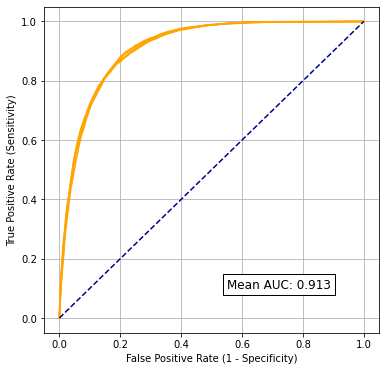

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(5):
    ax.plot(roc_fpr[i], roc_tpr[i], color='orange', linestyle='-')
ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.text(0.55, 0.1, f'Mean AUC: {mean_auc:0.3f}', fontsize=12, 
        bbox=dict(facecolor='w', alpha=1.0))
ax.grid()
filename = path + 'fully_connected_roc.jpg'
plt.savefig(filename, dpi=300)
plt.show()

Plot Sensitivity-Specificity Curve alongside Receiver Operator Characteristic Curve

In [13]:
k_fold_sensitivity = []
k_fold_specificity = []


for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed[i]
    proba = predicted_proba[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

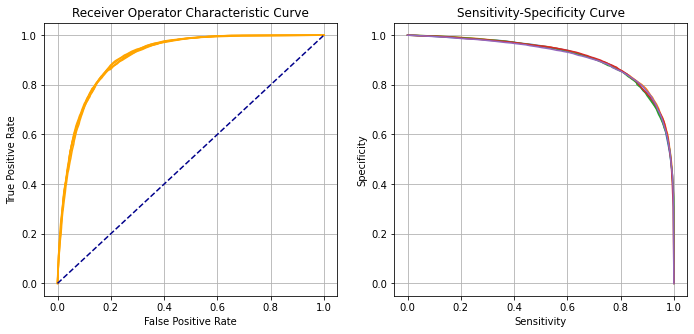

In [14]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(roc_fpr[i], roc_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig('./output/nn_fc_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [15]:
sens = np.array(k_fold_sensitivity).mean(axis=0)
spec = np.array(k_fold_specificity).mean(axis=0)
df = pd.DataFrame()
df['sensitivity'] = sens
df['specificity'] = spec
df['spec greater sens'] = spec > sens

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersect = get_intersect(a1, a2, b1, b2)[0]
print(f'\nIntersect: {intersect:0.3f}')


Intersect: 0.833


## Collate and save results

In [16]:
hospital_results = []
kfold_result = []
threshold_results = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['StrokeTeam']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    threshold_results.extend(list(np.repeat(thresholds[i], len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
model_results = pd.DataFrame()
model_results['hospital'] = hospital_results
model_results['observed'] = np.array(observed_results) * 1.0
model_results['prob'] = prob_results
model_results['predicted'] = predicted_results
model_results['k_fold'] = kfold_result
model_results['threshold'] = threshold_results
model_results['correct'] = model_results['observed'] == model_results['predicted']

# Save
filename = './predictions/nn_fc_k_fold.csv'
model_results.to_csv(filename, index=False)

## Calibration and assessment of accuracy when model has high confidence

In [17]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [18]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.023229,0.021323,0.978677,0.448138
0.2,0.145445,0.153043,0.846957,0.099046
0.3,0.248250,0.260789,0.739211,0.063748
0.4,0.349394,0.349146,0.650854,0.051975
0.5,0.450074,0.447220,0.552780,0.047387
0.6,0.551607,0.548530,0.548530,0.051738
0.7,0.652232,0.664149,0.664149,0.062343
0.8,0.752067,0.765447,0.765447,0.077872
0.9,0.846153,0.863245,0.863245,0.078378


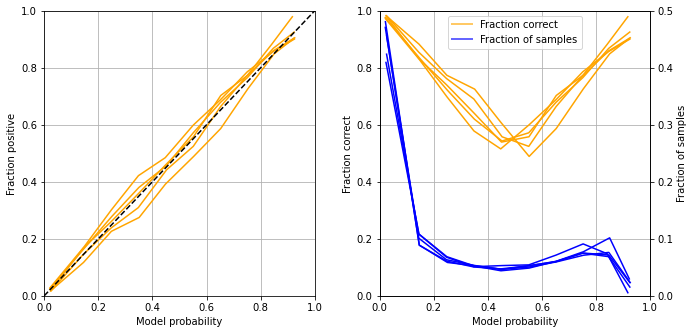

In [19]:
fig = plt.figure(figsize=(10,5))


# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.grid()

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid()

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)
plt.savefig('./output/nn_fc_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [20]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.645
Accuracy: 0.903


## Observations

* Overall accuracy = 84.4% (90.3% for those 65% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (89%) is greater than sensitivity (72%)
* The model can achieve 83.3% sensitivity and specificity simultaneously
* ROC AUC = 0.913